# STM Transit Delay Data Modeling

## Overview

This notebook explores tree-based machine learning models in order to find the one that predicts STM transit delays with the best accuracy. The featured models are XGBoost, LightGBM and CatBoost, because they are more suitable for large datasets with mixed data and high cardinality.

## Data Description

`exp_trip_duration`: Expected duration of a trip, in seconds.<br>
`route_direction_North`, `route_direction_South`, `route_direction_West`: Route direction in degrees.<br>
`route_type_Night`, `route_type_HighFrequency` : One-Hot features for types of bus lines<br>
`frequency_frequent`, `frequency_normal`, `frequency_rare`, `frequency_very_frequent`, `frequency_very_rare`: One-Hot features for number of arrivals per hour.<br>
`stop_location_group`: Stop cluster based on coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`trip_phase_middle`, `trip_phase_end`: One-Hot feature for trip progress.<br>
`exp_delay_prev_stop`: Expected duration between the previous and current stop, in seconds.<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`sch_rel_Scheduled`: One-Hot feature for schedule relationship.<br>
`time_of_day_evening`, `time_of_day_morning`, `time_of_day_night`: One-Hot features for time of day.<br>
`is_peak_hour`: Boolean value indicating if the sheduled arrival time is at peak hour.<br>
`temperature_2m`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity_2m`: Relative humidity at 2 meters above ground, in percentage.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure_msl`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed_10m`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction_10m`: Wind direction at 10 meters above ground.<br>

## Imports

In [1]:
from catboost import CatBoostRegressor
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shap
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import xgboost as xgb

In [2]:
# Load data
df = pd.read_parquet('../data/preprocessed.parquet')
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (1500000, 26)


## Split the data

In [3]:
# Separate features from target variable
X = df.drop('delay', axis=1)
y = df['delay']

The 3 models can run multiple iterations with a training and validation set. Therefore, a hold-out set will be kept to evaluate the final model.

In [4]:
# Train-validation-test split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

del X_temp
del y_temp

**Scaling**

Since only tree-based models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## Fit Base Models

All models allow to setup a number of rounds and early stopping. To start, all models will run 100 rounds with an early stopping of 3.

In [5]:
# Create dataframe to track metrics
reg_metrics_df = pd.DataFrame(columns=['model', 'MAE', 'RMSE', 'R²'])

In [6]:
def add_reg_metrics(reg_metrics_df:pd.DataFrame, y_pred:pd.Series, y_true:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_true, y_pred)
	rmse = root_mean_squared_error(y_true, y_pred)
	r2 = r2_score(y_true, y_pred)

	reg_metrics_df.loc[len(reg_metrics_df)] = [model_name, mae, rmse, r2]
	return reg_metrics_df

### XGBoost

In [7]:
# Create regression matrices
xg_train_data = xgb.DMatrix(X_train, y_train, enable_categorical=False)
xg_val_data = xgb.DMatrix(X_val, y_val, enable_categorical=False)
xg_test_data = xgb.DMatrix(X_test, y_test, enable_categorical=False)
xg_eval_set = [(xg_train_data, 'train'), (xg_val_data, 'validation')]
xg_test_set = [(xg_train_data, 'train'), (xg_test_data, 'test')]

In [8]:
# Train model
xg_reg_base = xgb.train(
  params= {'objective': 'reg:squarederror', 'tree_method': 'hist'},
  dtrain=xg_train_data,
  num_boost_round=100,
  evals=xg_eval_set,
  verbose_eval=10,
  early_stopping_rounds=3
)

[0]	train-rmse:156.46323	validation-rmse:155.71727
[10]	train-rmse:148.03189	validation-rmse:148.07687
[20]	train-rmse:145.54309	validation-rmse:145.91902
[30]	train-rmse:144.11409	validation-rmse:144.70793
[40]	train-rmse:142.91902	validation-rmse:143.75161
[50]	train-rmse:141.55458	validation-rmse:142.59166
[60]	train-rmse:140.69614	validation-rmse:141.90451
[70]	train-rmse:139.56006	validation-rmse:140.94534
[80]	train-rmse:138.69328	validation-rmse:140.24273
[90]	train-rmse:137.89886	validation-rmse:139.57982
[97]	train-rmse:137.62058	validation-rmse:139.47898


In [9]:
# Evaluate model
y_pred = xg_reg_base.predict(xg_val_data)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'xg_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.365457,139.478984,0.243542


**MAE**<br>
On average, the predictions are off by 70 seconds, which is reasonable, knowing that [STM](https://www.stm.info/en/info/networks/bus-network-and-schedules-enlightened) considers a bus arriving 3 minutes after the planned schedule being on time.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The model explains 24.35% of the variance, which is not good but understandable because of how random transit delays can be (bad weather, vehicle breakdown, accidents, etc.)

### LightGBM

In [10]:
# Create regression datasets
lgb_train_data = lgb.Dataset(X_train, label=y_train)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data)
lgb_test_data = lgb.Dataset(X_test, label=y_test, reference=lgb_train_data)

In [11]:
# Train model
lgb_reg_base = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': -1
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=3)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 25
[LightGBM] [Info] Start training from score 52.317412
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 145.977


In [12]:
# Evaluate model
y_pred = lgb_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'lgb_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.365457,139.478984,0.243542
1,lgb_reg_base,73.185825,145.976751,0.171420


The LightGBM model performs worse than XGBoost, especially in terms of R-squared.

### CatBoost

In [13]:
# Fit model
cat_reg_base = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=10,
    random_seed=42,
    verbose=10
)

cat_reg_base.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=3)

0:	learn: 160.3047745	test: 159.5508086	best: 159.5508086 (0)	total: 207ms	remaining: 20.5s
10:	learn: 155.0720266	test: 154.2661407	best: 154.2661407 (10)	total: 1.78s	remaining: 14.4s
20:	learn: 152.5198134	test: 151.7871580	best: 151.7871580 (20)	total: 3.01s	remaining: 11.3s
30:	learn: 151.1482569	test: 150.5139002	best: 150.5139002 (30)	total: 4.25s	remaining: 9.45s
40:	learn: 150.1356224	test: 149.5836087	best: 149.5836087 (40)	total: 5.51s	remaining: 7.93s
50:	learn: 149.2087764	test: 148.7391813	best: 148.7391813 (50)	total: 6.82s	remaining: 6.56s
60:	learn: 148.6057792	test: 148.2251318	best: 148.2251318 (60)	total: 8.15s	remaining: 5.21s
70:	learn: 148.0129444	test: 147.6992814	best: 147.6992814 (70)	total: 9.52s	remaining: 3.89s
80:	learn: 147.5463877	test: 147.2977566	best: 147.2977566 (80)	total: 10.9s	remaining: 2.57s
90:	learn: 146.9514147	test: 146.7248924	best: 146.7248924 (90)	total: 12.4s	remaining: 1.23s
99:	learn: 146.4551328	test: 146.2884541	best: 146.2884541 (99

In [14]:
# Evaluate model
y_pred = cat_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.365457,139.478984,0.243542
1,lgb_reg_base,73.185825,145.976751,0.171420
2,cat_reg_base,73.080722,146.288454,0.167877


CatBoost performs almost like LightGBM. So far, XGBoost seems to capture a bit more of the underlying patterns than the two other models.

## Hyperparameter Tuning

### XGBoost

In [15]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=2,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [16]:
# Best model
xg_best_model = random_search.best_estimator_
xg_best_params = random_search.best_params_

In [17]:
# Train best model with more boost rounds
xg_reg_tuned = xgb.train(
  params= {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'max_depth': xg_best_params['max_depth'],
    'learning_rate': xg_best_params['learning_rate'],
    'subsample': xg_best_params['subsample'],
    'colsample_bytree': xg_best_params['colsample_bytree'],
  },
  dtrain=xg_train_data,
  num_boost_round=10000,
  evals=xg_eval_set,
  verbose_eval=50,
  early_stopping_rounds=50
)

[0]	train-rmse:157.44938	validation-rmse:156.75882
[50]	train-rmse:140.30183	validation-rmse:141.66669
[100]	train-rmse:135.65984	validation-rmse:138.16842
[150]	train-rmse:132.54442	validation-rmse:136.15099
[200]	train-rmse:130.13743	validation-rmse:134.72254
[250]	train-rmse:128.53028	validation-rmse:134.03920
[300]	train-rmse:127.07783	validation-rmse:133.50085
[350]	train-rmse:125.60486	validation-rmse:132.82838
[400]	train-rmse:124.33808	validation-rmse:132.32552
[450]	train-rmse:123.35154	validation-rmse:132.12580
[500]	train-rmse:122.28692	validation-rmse:131.79863
[550]	train-rmse:121.46720	validation-rmse:131.66445
[600]	train-rmse:120.58133	validation-rmse:131.52871
[650]	train-rmse:119.86069	validation-rmse:131.52896
[657]	train-rmse:119.74549	validation-rmse:131.53226


In [18]:
# Evaluate model
y_pred = xg_reg_tuned.predict(xg_val_data)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'xg_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.365457,139.478984,0.243542
1,lgb_reg_base,73.185825,145.976751,0.171420
2,cat_reg_base,73.080722,146.288454,0.167877
3,xg_reg_tuned,66.431701,131.526843,0.327339


There's a significant improvement from the base XGBoost model and it's the best performing model so far.

### LightGBM

In [19]:
param_dist = {
  'n_estimators': [100, 500, 1000],
  'learning_rate': [0.01, 0.05, 0.1],
  'max_depth': [5, 10, 15],
  'num_leaves': [20, 31, 40],
  'min_child_samples': [10, 20, 30],
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=2, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 450000, number of used features: 25
[LightGBM] [Info] Start training from score 52.461629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 450000, number of used features: 25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

RandomizedSearchCV(cv=2, estimator=LGBMRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 500, 1000],
                                        'num_leaves': [20, 31, 40],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [20]:
# Best model
lgb_best_model = random_search.best_estimator_
lgb_best_params = random_search.best_params_

In [ ]:
# Train model with more boost rounds and early stopping
lgb_reg_tuned = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': lgb_best_params['n_estimators'],
        'learning_rate': lgb_best_params['learning_rate'],
        'max_depth': lgb_best_params['max_depth'],
        'num_leaves': lgb_best_params['num_leaves'],
        'min_child_samples': lgb_best_params['min_child_samples'],
        'subsample': lgb_best_params['subsample'],
        'colsample_bytree': lgb_best_params['colsample_bytree']
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=10000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 25
[LightGBM] [Info] Start training from score 52.317412
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 131.41


Exception ignored in: <function ResourceTracker.__del__ at 0x104603740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104467740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

In [22]:
# Evaluate model
y_pred = lgb_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'lgb_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.365457,139.478984,0.243542
1,lgb_reg_base,73.185825,145.976751,0.171420
2,cat_reg_base,73.080722,146.288454,0.167877
3,xg_reg_tuned,66.431701,131.526843,0.327339
4,lgb_reg_tuned,66.705643,131.410076,0.328533


The performance is very similar to the previous tuned model. The MAE is slightly worse but the RMSE and the R-squared are slightly better.

### CatBoost

In [ ]:
param_dist = {
  'iterations': [50, 100],
  'learning_rate': [0.01, 0.05, 0.1],
  'depth': [6, 8, 10],
  'l2_leaf_reg': [1, 3, 5],
  'border_count': [32, 64, 128],
  'bagging_temperature': [0, 1, 5],
}

cat_model = CatBoostRegressor(verbose=0, random_seed=42)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x12acc3110>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1, 5],
                                        'border_count': [32, 64, 128],
                                        'depth': [6, 8, 10],
                                        'iterations': [50, 100],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Exception ignored in: <function ResourceTracker.__del__ at 0x10aec3740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110303740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

In [24]:
# Best model
cat_best_model = random_search.best_estimator_
cat_best_params = random_search.best_params_

In [25]:
# Train best model with more iterations
cat_reg_tuned = CatBoostRegressor(
    iterations=10000,
    learning_rate=cat_best_params['learning_rate'],
    depth=cat_best_params['depth'],
    l2_leaf_reg=cat_best_params['l2_leaf_reg'],
    border_count=cat_best_params['border_count'],
    bagging_temperature=cat_best_params['bagging_temperature'],
    random_seed=42,
    verbose=50
)

cat_reg_tuned.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

0:	learn: 159.5114696	test: 158.7405904	best: 158.7405904 (0)	total: 141ms	remaining: 23m 30s
50:	learn: 146.4272900	test: 146.3167978	best: 146.3167978 (50)	total: 8.25s	remaining: 26m 49s
100:	learn: 143.0075464	test: 143.3240459	best: 143.3240459 (100)	total: 18s	remaining: 29m 20s
150:	learn: 140.4320123	test: 141.2274913	best: 141.2274913 (150)	total: 29.8s	remaining: 32m 25s
200:	learn: 138.4370914	test: 139.5905196	best: 139.5871121 (199)	total: 44.7s	remaining: 36m 20s
250:	learn: 136.7799254	test: 138.3306231	best: 138.3306231 (250)	total: 60s	remaining: 38m 48s
300:	learn: 135.2610737	test: 137.1289998	best: 137.1289998 (300)	total: 1m 15s	remaining: 40m 26s
350:	learn: 133.9055508	test: 136.0444552	best: 136.0444552 (350)	total: 1m 28s	remaining: 40m 27s
400:	learn: 132.7306003	test: 135.1621625	best: 135.1621625 (400)	total: 1m 41s	remaining: 40m 34s
450:	learn: 131.6685878	test: 134.4149139	best: 134.4149139 (450)	total: 1m 55s	remaining: 40m 41s
500:	learn: 130.7254585	te

In [26]:
# Evaluate model
y_pred = cat_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.365457,139.478984,0.243542
1,lgb_reg_base,73.185825,145.976751,0.171420
2,cat_reg_base,73.080722,146.288454,0.167877
3,xg_reg_tuned,66.431701,131.526843,0.327339
4,lgb_reg_tuned,66.705643,131.410076,0.328533
5,cat_reg_tuned,64.629312,128.341194,0.359529


CatBoost is the best performing model so far. This is the model that will be used for the rest of the analysis.

## Residual Analysis

In [27]:
# Get predictions
best_model = cat_reg_tuned
y_pred = best_model.predict(X_val)

In [28]:
def plot_residuals(y_true, y_pred, model_name:str) -> None:
	fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

	# Predicted vs. actual values
	ax1.scatter(x=y_pred, y=y_true)
	ax1.set_title('Predicted vs. Actual values')
	ax1.set_xlabel('Predicted Delay (seconds)')
	ax1.set_ylabel('Actual Delay (seconds)')
	ax1.grid(True)

	# Residuals
	residuals = y_true - y_pred
	ax2.scatter(x=y_pred, y=residuals)
	ax2.set_title('Residual Plot')
	ax2.set_xlabel('Predicted Delay (seconds)')
	ax2.set_ylabel('Residuals (seconds)')
	ax2.axhline(0, linestyle='--', color='orange')
	ax2.grid(True)

	fig.suptitle('Residual Analysis', fontsize=18)
	fig.tight_layout()
	fig.savefig(f'../images/residual_analysis_{model_name}.png', bbox_inches='tight')
	plt.show()

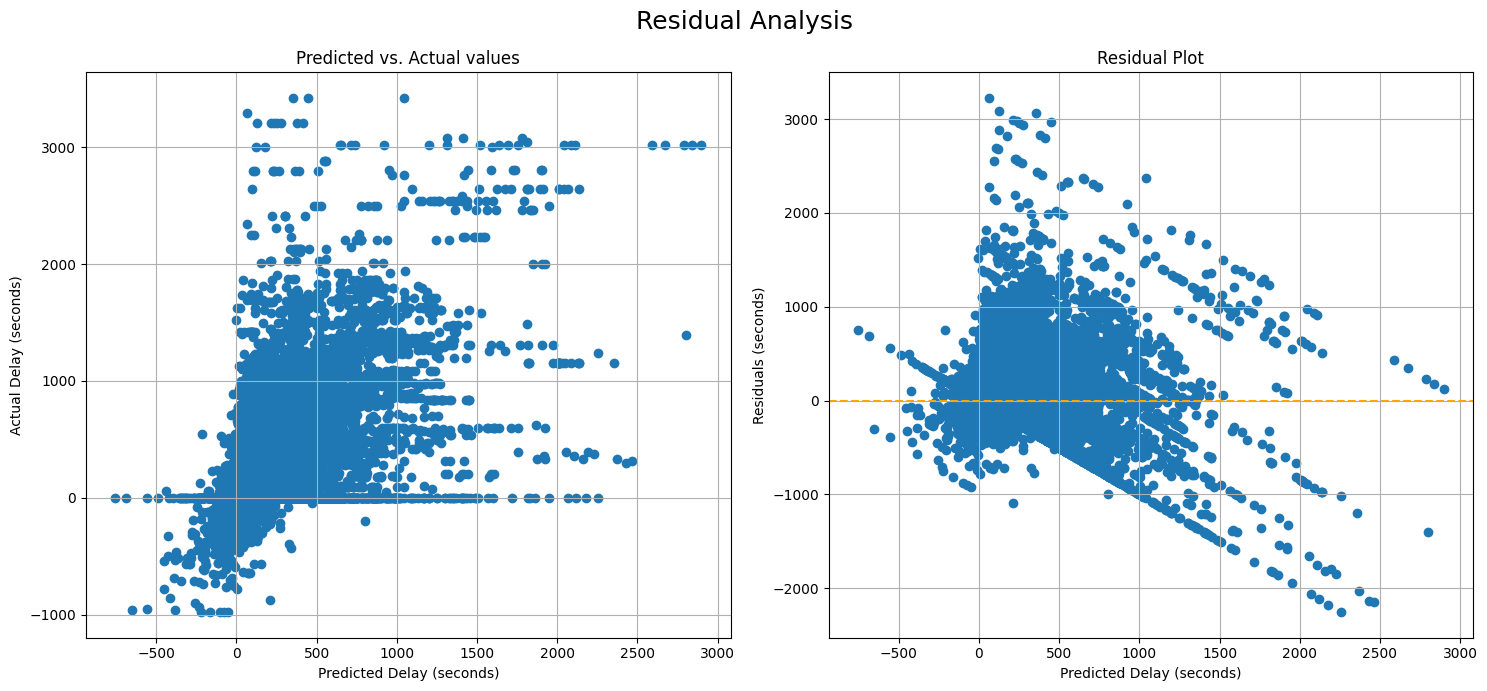

In [29]:
# Plot residuals
plot_residuals(y_val, y_pred, 'cat_reg_tuned')

**Predicted vs. Actual Plot**

There's a dense cluster around 0 for both predicted and actual values, indicating many predictions and centered near 0. However, there is substantial spread both above and below the diagonal line, which suggests underprediction and overprediction. There are clear outliers that are far from the main cluster.


**Residual Plot**

The residuals show a visible funnel shapes, which indicates a systematic error in prediction. The spread of residuals increases as the predicted delay increases. This is a sign of heteroscedasticity (the variance of errors is not constant across all predictions).

## Feature Importance Plot

In [30]:
def plot_feat_importance(feature_importances, model_name:str) -> None:
	plt.figure(figsize=(10, 6))
	plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
	plt.gca().invert_yaxis()
	plt.title('Feature Importance')
	plt.xlabel('Importance')
	plt.tight_layout()
	plt.savefig(f'../images/feature_importances_{model_name}.png', bbox_inches='tight')
	plt.show()

In [32]:
# Get sorted feature importances
feature_importances = best_model.get_feature_importance(prettified=True)
feature_importances = feature_importances.sort_values(by='Importances', ascending=False)
feature_importances.head()

,Feature Id,Importances
0,exp_trip_duration,24.483094
1,hist_avg_delay,16.322255
2,stop_location_group,8.990957
3,temperature_2m,7.185348
4,wind_direction_10m,6.486950


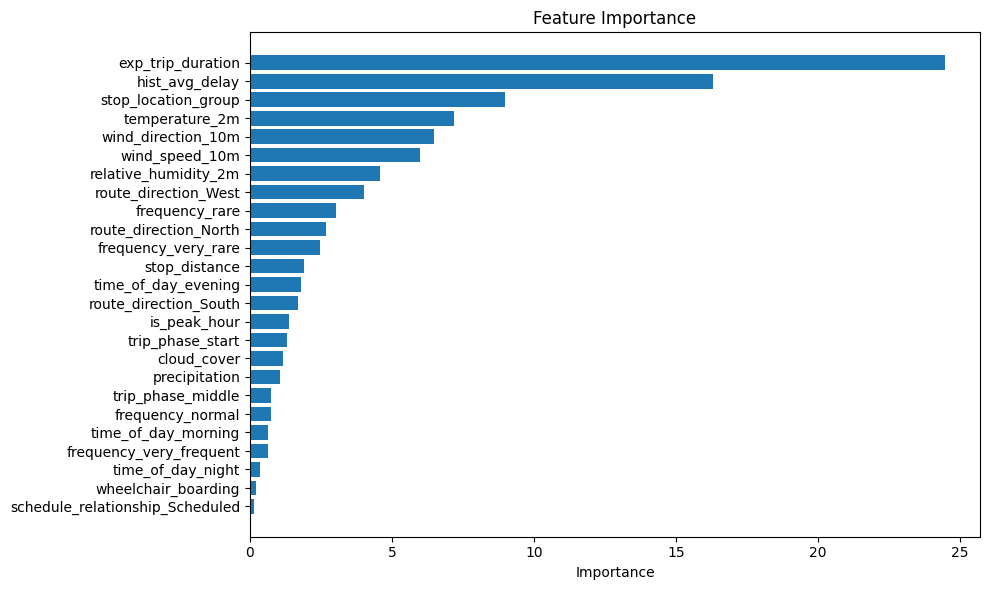

In [33]:
# Plot the feature importance
plot_feat_importance(feature_importances, 'cat_reg_tuned')

**Most Important Features:**
- `exp_trip_duration` This is the most important feature in the model. It seems like the expected trip duration is highly predictive of the actual delay. This makes sense as longer expected trips are more prone to disruptions and variations.
- `hist_avg_delay` Historical average delay is the second most important predictor. This aligns well with time series predictability since past delays often indicate patterns or bottlenecks that repeat over time.
- `stop_location_group` This is also highly influential. Grouping the stops by location might be capturing specific problematic areas or geographic patterns that contribute to delays (e.g., heavy traffic zones, construction areas, major intersections).
- `temperature_2m`, `wind_direction_10m` Weather conditions do play a role, but not as heavily as trip-related features. The fact that wind direction and temperature are relatively impactful suggests weather variability might affect delays more than just precipitation alone.

**Least Important Features:**
- `is_peak_hour` This is surprisingly less impactful than expected. It suggests that perhaps peak hours are not as unpredictable as other features.
- `time_of_day_morning`, `time_of_day_night` Evening seems to be more influential than morning or night, which could indicate evening rush hour impacts.
- `frequency_very_frequent` The bus frequency is contributing to the prediction. More frequent buses might be less susceptible to delays since missed connections or unexpected traffic issues don't accumulate as much.
- `wheelchair_boarding` Very low importance, indicating it has minimal influence on delays.
- `schedule_relationship_Scheduled` This has almost no impact, which might indicate that deviations from scheduled times are not systematically captured by the model.

## SHAP Plots

In [37]:
def shap_plot(shap_values, X_true, model_name:str, barplot:bool=True) -> None:
	if barplot:
		shap.summary_plot(shap_values, X_true, plot_type='bar', show=False)
		plt.title('SHAP Summary Barplot')
		plot_type = 'barplot' 
	else: # beeswarm
		shap.summary_plot(shap_values, X_true, show=False)
		plt.title('SHAP Summary Beeswarm Plot')
		plot_type = 'beeswarm_plot' 
	plt.tight_layout()
	plt.savefig(f'../images/shap_{plot_type}_{model_name}.png', bbox_inches='tight')
	plt.show()

In [86]:
def shap_single_pred(X_true, explainer, shap_values, model_name:str) -> None:
	index = random.randrange(len(X_true))
	shap.force_plot(
		explainer.expected_value,
		shap_values[index, :],
		X_true.iloc[index, :],
		figsize=(15, 4),
		contribution_threshold=0.075,
		matplotlib=True,
		show=False)
	plt.tight_layout()
	plt.savefig(f'../images/shap_force_plot_{model_name}.png', bbox_inches='tight')
	plt.show()

In [34]:
# Initialize SHAP
sample_size = 250 # sample validation set to prevent memory overload
X_val_sample = X_val.sample(n=sample_size, random_state=42) 
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_sample)

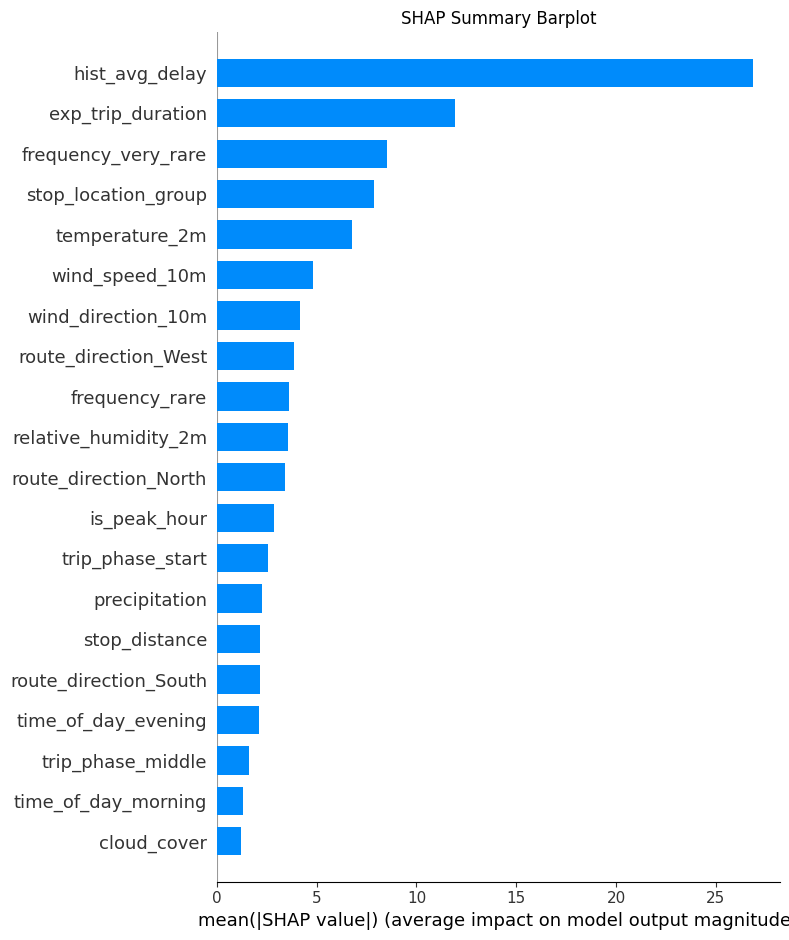

In [38]:
# Summary barplot
shap_plot(shap_values, X_val_sample, 'cat_reg_tuned', barplot=True)

- The ranking matches the feature importances plot:
	- `hist_avg_delay` and `exp_trip_duration` dominate the list, with a substantial gap from the rest.
	- `frequency_very_rare` and `stop_location_group` are also critical.
	- Weather (`temperature_2m`, `wind_speed_10m`) plays a moderate role.

**Insight:**

The impact of weather is not that high. It's probably because the data has been collected in spring and usually, there are not extreme weather conditions at that time of the year.

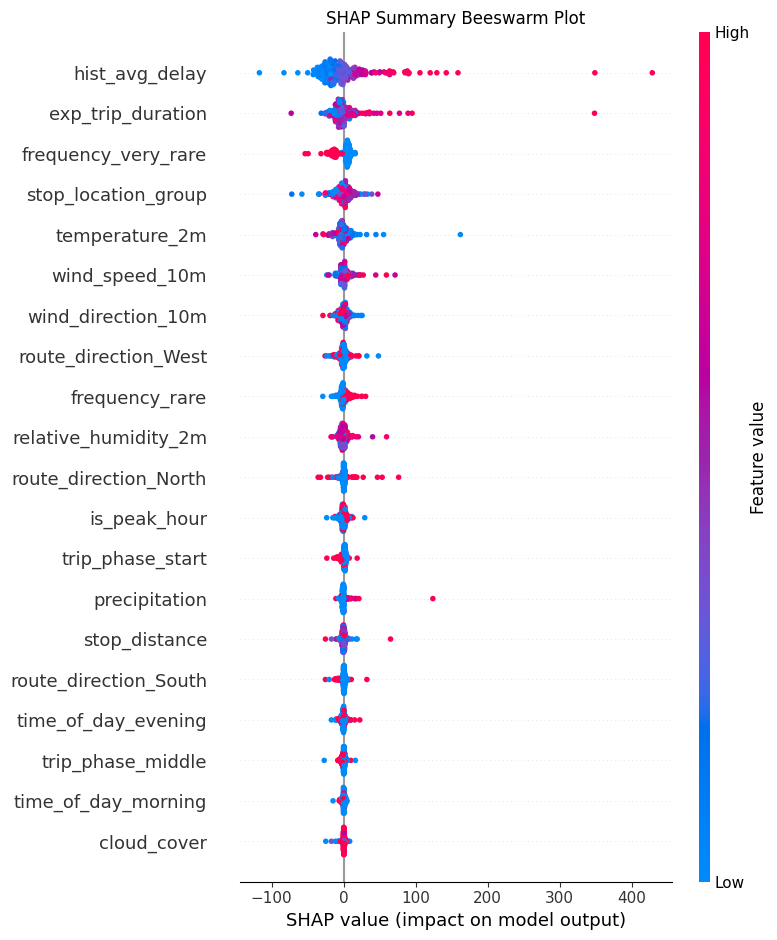

In [39]:
# Summary beeswarm plot
shap_plot(shap_values, X_val_sample, 'cat_reg_tuned', barplot=False)

The beeswarm plot offers a global view of all predictions and their feature influences.

- `hist_avg_delay` and `exp_trip_duration` are the top features:
	- High values of hist_avg_delay (in red) push predictions higher.
	- For `exp_trip_duration`, high values both increase and decrease the delay prediction, indicating complex interactions.
- Color Representation:
	- Red = High feature value, Blue = Low feature value.
	- For example, when `route_direction_West` is true, it pushes the prediction up. When it is low, it has little to no effect.
- Weather Variables:
	- `temperature_2m`, `wind_speed_10m`, and `wind_direction_10m` also affect predictions. For instance, higher wind speeds push predictions slightly upwards, which makes sense given that weather disturbances can slow down traffic.
- Time of Day:
	- Evening seems to affect delay more than morning or night, aligning with typical rush hour traffic.

**Insight:**

The high influence of `hist_avg_delay` confirms that delay is highly dependent on past performance. This could be useful for forecasting in specific segments or optimizing bus routes during peak times.

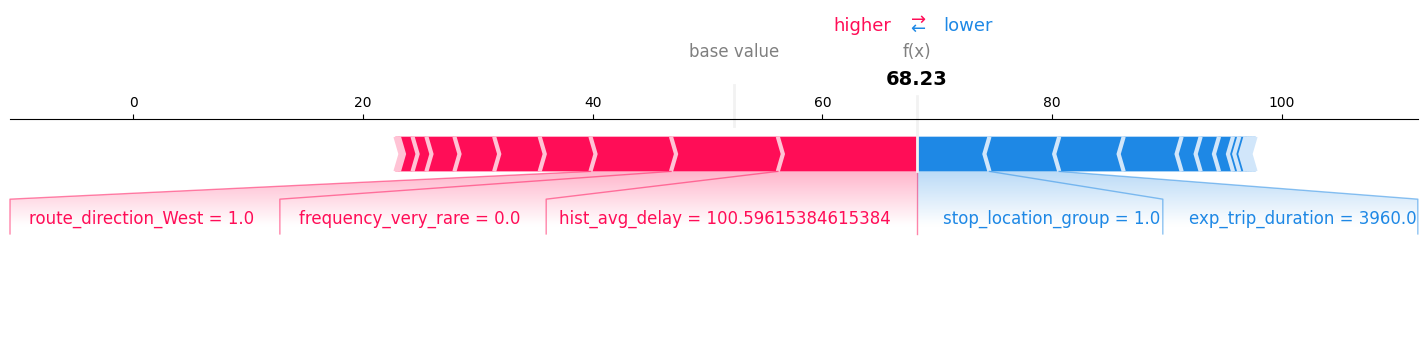

In [54]:
# Force plot a single prediction
shap_single_pred(X_val_sample, explainer, shap_values, 'cat_reg_tuned')

This plot is a breakdown of the specific prediction (`68.23`) for one instance.

- Features that increase the prediction (red):
	- `route_direction_West`: When the bus is going West, it strongly increases the delay.
	- `frequency_very_rare`: If the bus service is rare, it also increases the expected delay.
	- `hist_avg_delay`: A large historical average delay of `100.59` also pushes the prediction up significantly.
- Features that decrease the prediction (blue):
	- `stop_location_group`: A value of `1.0` (extreme West of Montreal) for the stop group reduces the delay.
	- `exp_trip_duration`: An expected trip duration of `3960.0` seconds also reduces the delay, which is a bit surprising. This might indicate that long trips in this grouping tend to be managed better.<br><br>

**Insight:**

The model predicts more delay (`68.23`) when:
- The bus heads West.
- It is part of a rare frequency group.
- Historical delays have been high.

## Feature Elimination Based on SHAP Values

In [58]:
# Calculate mean SHAP per feature
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X_val.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values('mean_abs_shap')
shap_df.head()

,feature,mean_abs_shap
0,wheelchair_boarding,0.308548
17,time_of_day_night,0.476308
20,frequency_very_frequent,0.773753
11,schedule_relationship_Scheduled,0.843004
18,frequency_normal,1.199620


In [59]:
# Identify low impact features (below 1)
low_shap_features = shap_df[shap_df['mean_abs_shap'] < 1]

print('One-hot features with low SHAP impact to remove:\n')
print(low_shap_features)

One-hot features with low SHAP impact to remove:

                            feature  mean_abs_shap
0               wheelchair_boarding       0.308548
17                time_of_day_night       0.476308
20          frequency_very_frequent       0.773753
11  schedule_relationship_Scheduled       0.843004


In [ ]:
# Keep best features
features_to_drop = low_shap_features['feature'].tolist()
all_features = X.columns.tolist()

diff = set(all_features) - set(features_to_drop)
best_features = list(diff)
best_features = sorted(best_features)

In [61]:
# Remove columns from input matrices
X_pruned = X[best_features]
X_train_pruned = X_train[best_features]
X_val_pruned = X_val[best_features]
X_test_pruned = X_test[best_features]

## Retrain Model with Best Features

In [62]:
# Retrain Model
cat_reg_pruned = CatBoostRegressor(
    iterations=10000,
    learning_rate=cat_best_params['learning_rate'],
    depth=cat_best_params['depth'],
    l2_leaf_reg=cat_best_params['l2_leaf_reg'],
    border_count=cat_best_params['border_count'],
    bagging_temperature=cat_best_params['bagging_temperature'],
    random_seed=42,
    verbose=50
)

cat_reg_tuned.fit(X_train_pruned, y_train, eval_set=(X_val_pruned, y_val), early_stopping_rounds=50)

0:	learn: 159.5595123	test: 158.7740431	best: 158.7740431 (0)	total: 238ms	remaining: 39m 36s
50:	learn: 146.1547166	test: 146.0494466	best: 146.0494466 (50)	total: 8.11s	remaining: 26m 22s
100:	learn: 142.6432027	test: 143.0093043	best: 143.0093043 (100)	total: 16.4s	remaining: 26m 50s
150:	learn: 140.0834274	test: 140.8991869	best: 140.8991869 (150)	total: 26.3s	remaining: 28m 37s
200:	learn: 138.2185333	test: 139.4086932	best: 139.4086932 (200)	total: 37.7s	remaining: 30m 40s
250:	learn: 136.4556743	test: 138.0341554	best: 138.0341554 (250)	total: 52.2s	remaining: 33m 46s
300:	learn: 135.2104598	test: 137.1452551	best: 137.1452551 (300)	total: 1m 3s	remaining: 34m 13s
350:	learn: 133.8365548	test: 136.0533618	best: 136.0533618 (350)	total: 1m 16s	remaining: 34m 50s
400:	learn: 132.6840905	test: 135.2552897	best: 135.2493552 (399)	total: 1m 31s	remaining: 36m 19s
450:	learn: 131.6715715	test: 134.5635824	best: 134.5635824 (450)	total: 1m 43s	remaining: 36m 23s
500:	learn: 130.6931781

In [64]:
# Evaluate model
y_pred = cat_reg_tuned.predict(X_val_pruned)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_pruned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.365457,139.478984,0.243542
1,lgb_reg_base,73.185825,145.976751,0.171420
2,cat_reg_base,73.080722,146.288454,0.167877
3,xg_reg_tuned,66.431701,131.526843,0.327339
4,lgb_reg_tuned,66.705643,131.410076,0.328533
5,cat_reg_tuned,64.629312,128.341194,0.359529
6,cat_reg_pruned,65.115093,128.653813,0.356405


The model metrics with less features are similar, which means eliminating features didn't worsen the performance too much.

## Retune Parameters

In [65]:
param_dist = {
  'iterations': [50, 100],
  'learning_rate': [0.01, 0.05, 0.1],
  'depth': [6, 8, 10],
  'l2_leaf_reg': [1, 3, 5],
  'border_count': [32, 64, 128],
  'bagging_temperature': [0, 1, 5],
}

cat_model = CatBoostRegressor(verbose=0, random_seed=42)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_pruned, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x12cbd2180>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1, 5],
                                        'border_count': [32, 64, 128],
                                        'depth': [6, 8, 10],
                                        'iterations': [100, 200],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [66]:
# Best model
cat_pruned_best_model = random_search.best_estimator_
cat_pruned_best_params = random_search.best_params_

In [67]:
# Retrain model
cat_reg_final = CatBoostRegressor(
    iterations=10000,
    learning_rate=cat_pruned_best_params['learning_rate'],
    depth=cat_pruned_best_params['depth'],
    l2_leaf_reg=cat_pruned_best_params['l2_leaf_reg'],
    border_count=cat_pruned_best_params['border_count'],
    bagging_temperature=cat_pruned_best_params['bagging_temperature'],
    random_seed=42,
    verbose=50
)

cat_reg_final.fit(X_train_pruned, y_train, eval_set=(X_val_pruned, y_val), early_stopping_rounds=50)

0:	learn: 159.5900262	test: 158.7911286	best: 158.7911286 (0)	total: 359ms	remaining: 59m 50s
50:	learn: 146.3950857	test: 146.2068627	best: 146.2068627 (50)	total: 8.72s	remaining: 28m 21s
100:	learn: 142.8363507	test: 143.0856610	best: 143.0856610 (100)	total: 17.3s	remaining: 28m 17s
150:	learn: 140.2062342	test: 140.8580184	best: 140.8580184 (150)	total: 26.2s	remaining: 28m 25s
200:	learn: 138.2690468	test: 139.2907449	best: 139.2907449 (200)	total: 34.9s	remaining: 28m 22s
250:	learn: 136.6507432	test: 138.1091681	best: 138.1037535 (249)	total: 43.9s	remaining: 28m 23s
300:	learn: 135.2088859	test: 136.9836211	best: 136.9836211 (300)	total: 53.2s	remaining: 28m 34s
350:	learn: 133.7948604	test: 135.8771989	best: 135.8771989 (350)	total: 1m 2s	remaining: 28m 33s
400:	learn: 132.7222055	test: 135.1176638	best: 135.1176638 (400)	total: 1m 11s	remaining: 28m 34s
450:	learn: 131.7378692	test: 134.4571073	best: 134.4571073 (450)	total: 1m 20s	remaining: 28m 33s
500:	learn: 130.7748886	

Exception ignored in: <function ResourceTracker.__del__ at 0x111187740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10b88b740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

1000:	learn: 124.3565806	test: 130.0143076	best: 130.0143076 (1000)	total: 3m 27s	remaining: 31m 1s
1050:	learn: 123.9408279	test: 129.8357616	best: 129.8357616 (1050)	total: 3m 37s	remaining: 30m 48s


Exception ignored in: <function ResourceTracker.__del__ at 0x105abf740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10780b740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

1100:	learn: 123.5429652	test: 129.7030764	best: 129.7030764 (1100)	total: 3m 47s	remaining: 30m 35s
1150:	learn: 123.1573841	test: 129.5067211	best: 129.5067211 (1150)	total: 3m 56s	remaining: 30m 18s
1200:	learn: 122.7621571	test: 129.3110833	best: 129.3110833 (1200)	total: 4m 5s	remaining: 29m 58s
1250:	learn: 122.3668621	test: 129.1492443	best: 129.1492443 (1250)	total: 4m 14s	remaining: 29m 39s
1300:	learn: 122.0130446	test: 129.0149587	best: 129.0149587 (1300)	total: 4m 23s	remaining: 29m 22s
1350:	learn: 121.6944568	test: 128.9024975	best: 128.9024975 (1350)	total: 4m 32s	remaining: 29m 4s
1400:	learn: 121.3408470	test: 128.7608999	best: 128.7608999 (1400)	total: 4m 42s	remaining: 28m 54s
1450:	learn: 121.0137699	test: 128.7102039	best: 128.7025291 (1438)	total: 4m 53s	remaining: 28m 47s
1500:	learn: 120.6883998	test: 128.5980205	best: 128.5939065 (1499)	total: 5m 2s	remaining: 28m 35s
1550:	learn: 120.3751881	test: 128.5117604	best: 128.5117604 (1550)	total: 5m 12s	remaining: 2

## Final Model

### Evaluate with Test Set

In [68]:
final_model = cat_reg_final

In [69]:
# Evaluate model
y_pred = final_model.predict(X_test_pruned)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_test, 'cat_reg_final')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.365457,139.478984,0.243542
1,lgb_reg_base,73.185825,145.976751,0.171420
2,cat_reg_base,73.080722,146.288454,0.167877
3,xg_reg_tuned,66.431701,131.526843,0.327339
4,lgb_reg_tuned,66.705643,131.410076,0.328533
5,cat_reg_tuned,64.629312,128.341194,0.359529
6,cat_reg_pruned,65.115093,128.653813,0.356405
7,cat_reg_final,64.323865,127.055103,0.362549


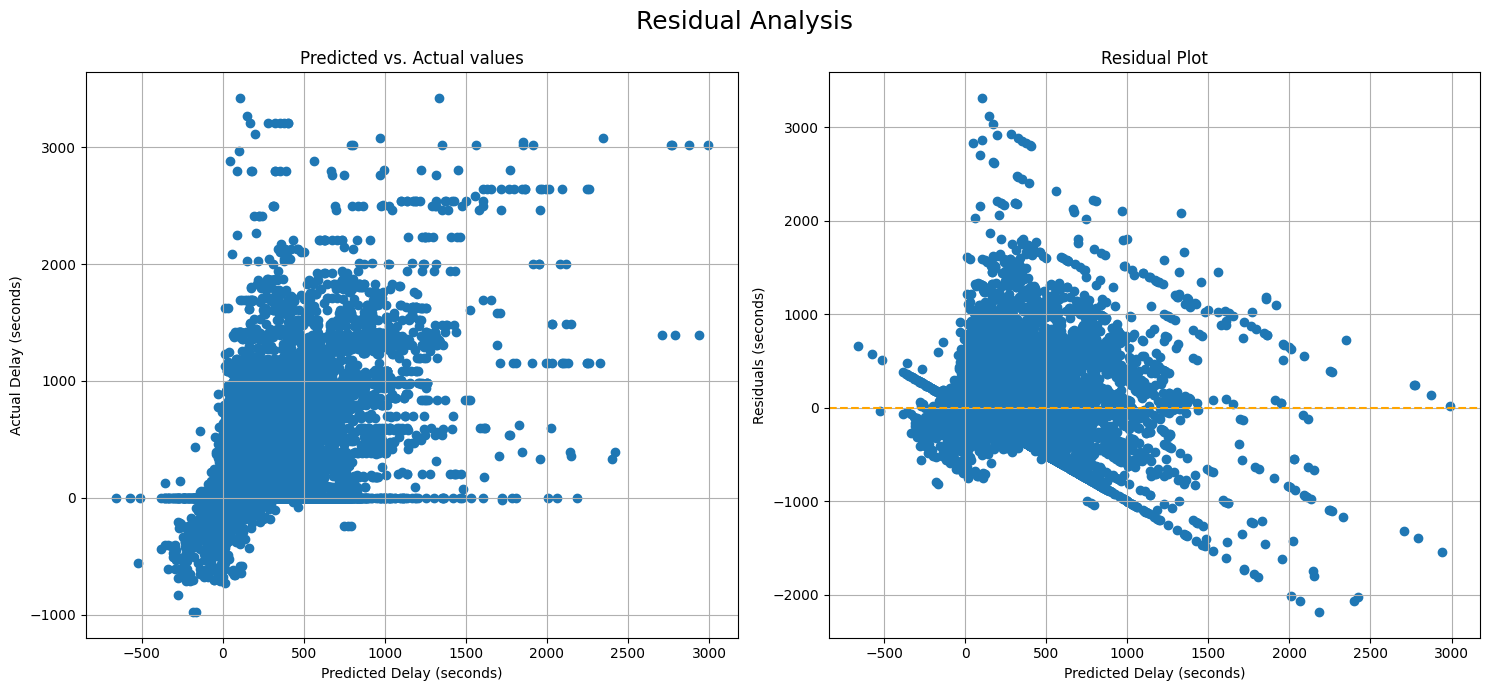

In [70]:
# Plot residuals
plot_residuals(y_test, y_pred, 'cat_reg_final')

### Feature importances

In [71]:
# Get top 5 most important features
feature_importances = final_model.get_feature_importance(prettified=True)
feature_importances = feature_importances.sort_values(by='Importances', ascending=False)
feature_importances.head()

,Feature Id,Importances
0,exp_trip_duration,23.919707
1,hist_avg_delay,16.250297
2,stop_location_group,9.529559
3,temperature_2m,7.349494
4,wind_direction_10m,6.485102


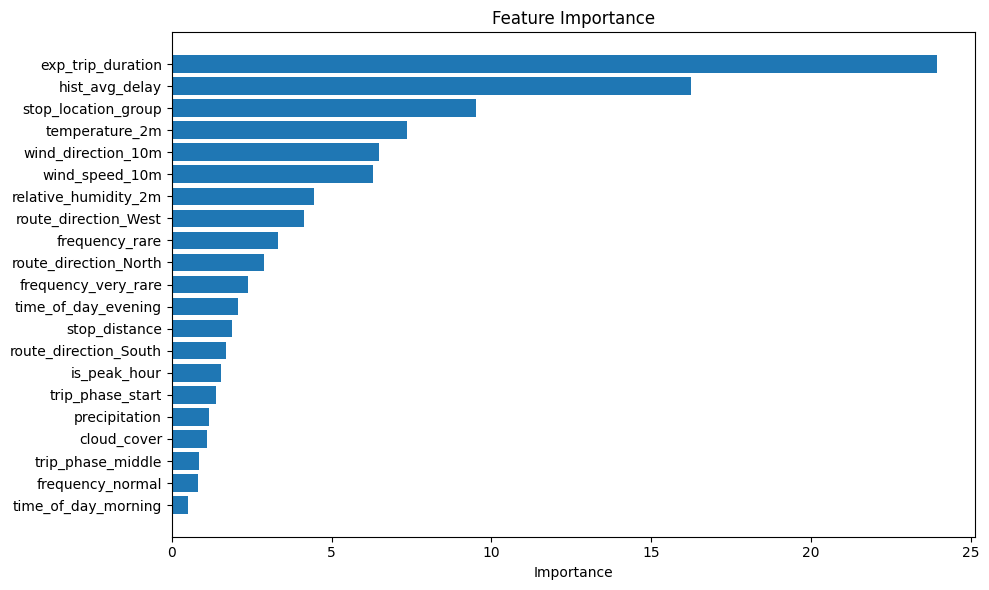

In [72]:
# Plot the feature importance
plot_feat_importance(feature_importances, 'cat_reg_final')

### SHAP Plots

In [76]:
# Initialize SHAP
sample_size = 250 # sample validation set to prevent memory overload
X_test_sample = X_test_pruned.sample(n=sample_size, random_state=42) 
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_sample)

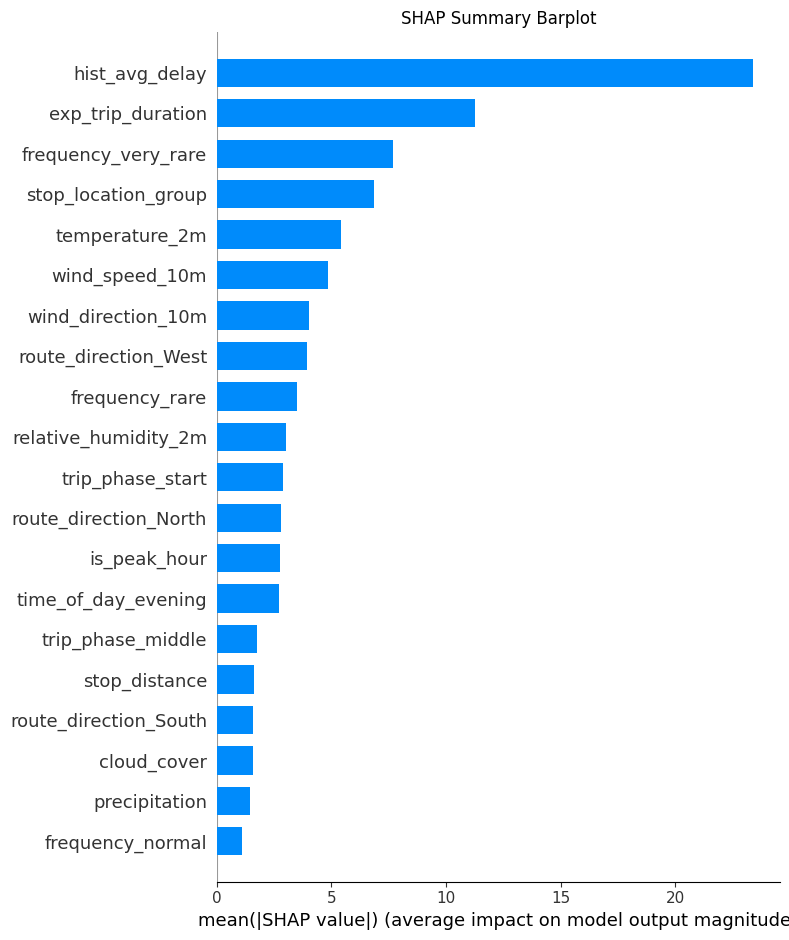

In [77]:
# Summary barplot
shap_plot(shap_values, X_test_sample, 'cat_reg_final', barplot=True)

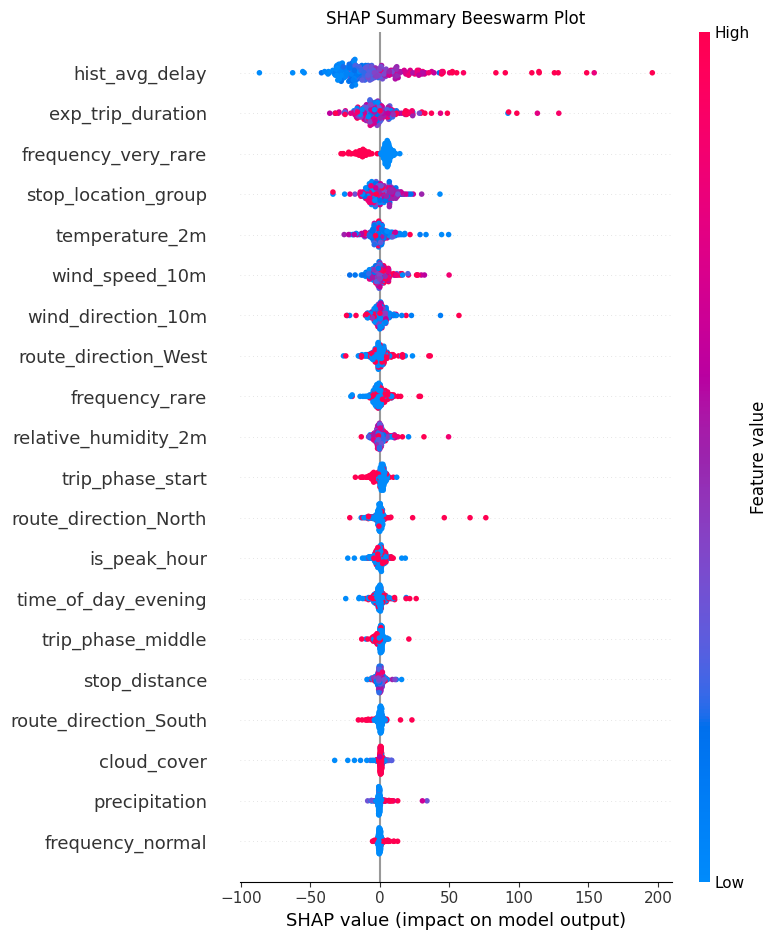

In [78]:
# Summary beeswarm plot
shap_plot(shap_values, X_test_sample, 'cat_reg_final', barplot=False)

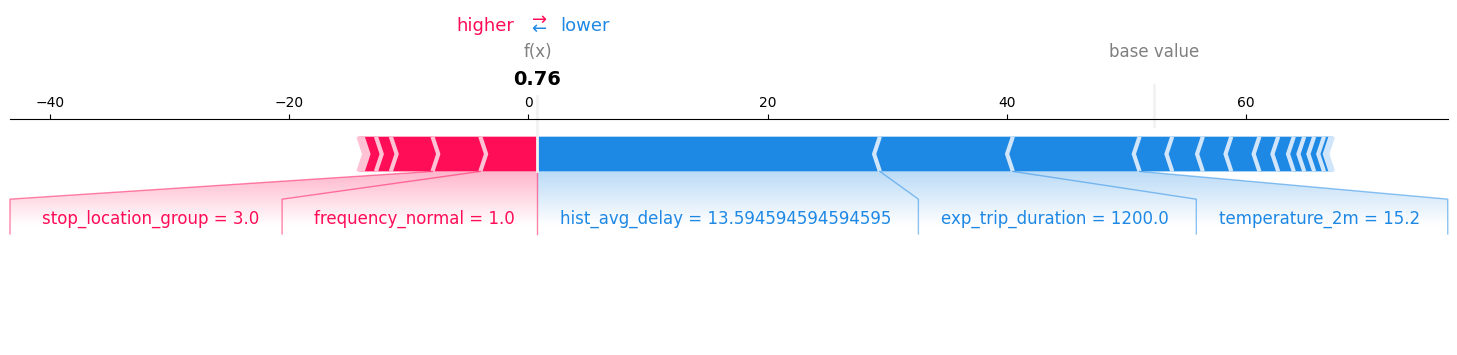

In [87]:
# Force plot a single prediction
shap_single_pred(X_test_sample, explainer, shap_values, 'cat_reg_final')

### Make Prediction

In [88]:
# Load stop coordinates scaler
scaler_coords = joblib.load('../models/scaler_coords.pkl')

In [95]:
# Get features order
best_features = X_test_pruned.columns.tolist()
best_features

['exp_trip_duration',
 'relative_humidity_2m',
 'wind_direction_10m',
 'precipitation',
 'time_of_day_morning',
 'hist_avg_delay',
 'route_direction_South',
 'wind_speed_10m',
 'frequency_normal',
 'time_of_day_evening',
 'stop_location_group',
 'is_peak_hour',
 'trip_phase_middle',
 'frequency_very_rare',
 'route_direction_North',
 'route_direction_West',
 'frequency_rare',
 'temperature_2m',
 'stop_distance',
 'cloud_cover',
 'trip_phase_start']

In [96]:
# Create feature matrix
test_input = {
	'exp_trip_duration': [3600],
	'relative_humidity_2m': [60],
	'wind_direction_10m': [140],
	'precipitation': [0],
	'time_of_day_morning': [0],
	'hist_avg_delay': [300],
	'route_direction_South': [0],
	'wind_speed_10m': [10],
	'frequency_normal': [1],
	'time_of_day_evening': [0],
	'stop_location_group': [2],
	'is_peak_hour': [1],
	'trip_phase_middle': [0],
	'frequency_very_rare': [0],
	'route_direction_North': [0],
	'route_direction_West': [1],
	'frequency_rare': [0],
	'temperature_2m': [24.3],
	'stop_distance': [400],
	'cloud_cover': [0],
	'trip_phase_start': [0]
}

x_test = pd.DataFrame(test_input)

In [100]:
# Predict delay
prediction = final_model.predict(x_test)
print(f'Predicted delay: {prediction[0]:.2f} seconds')

Predicted delay: 34.48 seconds


### Export Data

In [ ]:
# Save model, hyperparameters and predictors
joblib.dump(final_model, '../models/regression_model.pkl')
joblib.dump(cat_pruned_best_params, '../models/best_hyperparams.pkl')
joblib.dump(best_features, '../models/best_features.pkl')

['../models/best_features.pkl']

## End